In [1]:
import string
import copy
import scipy
import Tkinter, tkFileDialog
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import os
import re
import sys
import cPickle
import glob
from PIL import Image, ImageDraw, ImageColor
sys.path.append(os.path.abspath("C:\Users\Scherer Lab E\Documents\GitHub\Python_Data_Analysis"))
import half_nanoplate_functions as hnf
import common_functions
%matplotlib inline

C:\Users\Scherer Lab E\Anaconda2\envs\161011\lib\site-packages\skimage\viewer\utils\core.py:10: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  warn("Recommended matplotlib backend is `Agg` for full "


When calculating the pmf at the barrier we found an issue with L=3 where the hight of the barrier is not as high as teh bulk ring trap in some cases. In order to determine where this comes from I am look at the effects of my particle localization cleanup code has on the histograms of particle positions in theta at the barrier.

## Import the data

Import the processed data processed in __Ana_16052001__ in addition to the raw particle data before culling all the spurious particles.

In [2]:
os.chdir("K:\Pat's_Projects\ParticleTrajectoryData")
store = pd.HDFStore('half_nanoplate_dynamics_processed.h5', mode='r')

In [3]:
'''Import the Original Half Nanoplate Data'''
data_dir="C:\Users\Scherer Lab E\Downloads\TrackingGUI_and_associated_files_20July2014 My Version"
os.chdir(data_dir)
file_list = glob.glob('Mov_012014*linked.pandas')
data_list = [pd.read_pickle(i) for i in file_list]

In [4]:
'''Import Uncut Original Half Nanoplate Data'''
data_dir="C:\Users\Scherer Lab E\Downloads\TrackingGUI_and_associated_files_20July2014 My Version"
os.chdir(data_dir)
file_list_uncut = glob.glob('Mov_012014*pre-linking.mat')
data_list_uncut = [common_functions.import_matlab_gui(i) for i in file_list_uncut]
data_list_uncut = [common_functions.matlab_gui_to_data_frame(i) for i in data_list_uncut]

Loading Mov_01201403_pre-linking.mat
Loading Mov_01201404_pre-linking.mat
Loading Mov_01201405_pre-linking.mat
Loading Mov_01201406_pre-linking.mat
Loading Mov_01201407_pre-linking.mat
Loading Mov_01201408_pre-linking.mat


In [5]:
'''Import the Matlab Gui Data'''
data_dir="C:\Users\Scherer Lab E\Downloads\TrackingGUI_and_associated_files_20July2014 My Version"
os.chdir(data_dir)
file_list_proc = glob.glob('Mov_012014*pre-linking_processed_2.mat')
data_list_proc = [common_functions.import_matlab_gui(i) for i in file_list_proc]
data_list_proc = [hnf.matlab_gui_to_data_frame_with_intesity(i) for i in data_list_proc]

Loading Mov_01201403_pre-linking_processed_2.mat
Loading Mov_01201404_pre-linking_processed_2.mat
Loading Mov_01201405_pre-linking_processed_2.mat
Loading Mov_01201406_pre-linking_processed_2.mat
Loading Mov_01201407_pre-linking_processed_2.mat
Loading Mov_01201408_pre-linking_processed_2.mat


In [6]:
'''Do y-flip of position data and add polar coordinates'''
transformed_data_list_proc = []
for df in data_list_proc:
    new_flip = common_functions.y_axis_flip(df, 390)
    temp_fit_params = common_functions.least_sq_fit_circle(new_flip)
    common_functions.polar_coor_data_frame(new_flip, temp_fit_params[0], temp_fit_params[1])
    transformed_data_list_proc.append(new_flip)

In this document I compare the distributions of particle positions in theta for different L's using different methods of cleaning up spurious particles. I want to stress that the range of the histogram is constant for all the plots (255 to 280 degrees). Bin width optimization is used on the "Final Culled Positions" data set to determine the bin width for the other histograms at that L. Since "Final Culled Positions" never changes that means that the bin width for a given L is constant throughout the document. For example, all L=1 histograms have 29 bins in the range of 255-280, all L=2 histograms have 48 bins in the range of 255-280, etc.

## Compare Raw Positions to Final Culled Positions

The first comparison is between the histogram of the particle positions that come from the particle tracking vs the positions after cleaning up the positions. "Raw Positions" are the ones from the particle tracking software while "Final Culled Positions" are the positions after removing spurious particles from __Ana_16053001__ and the ones that have been used in all the other analysis thus far.

You can see that the shape at the barrier changes after the culling of particles. There is an increase in pdf in the 273-275 degree region.

29


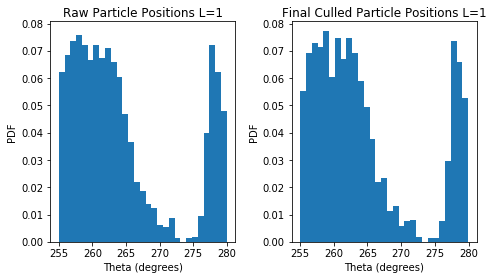

48


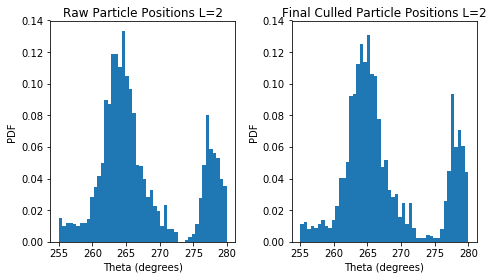

47


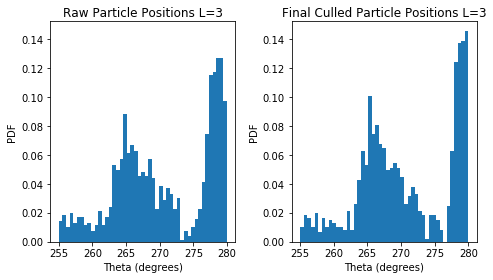

19


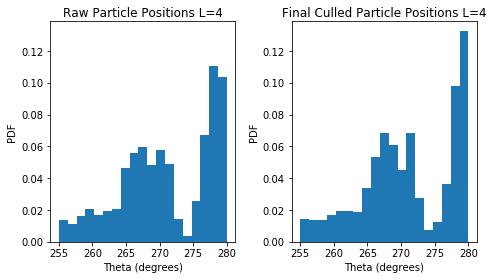

25


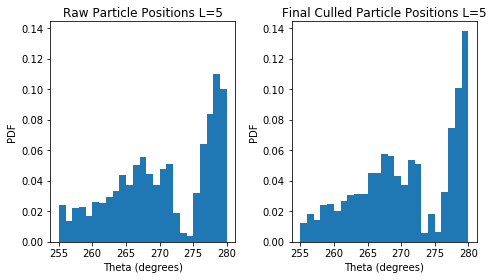

In [7]:
keys = store.index['key']
theta_range = [255, 280]
for l in range(5):
    plt.figure(figsize=[7,4])
    culled_positions = store.get(keys[l]).copy()
    culled_positions = culled_positions.drop_duplicates(['frame', 'track id'])
    culled_positions = culled_positions.query('@theta_range[0] < theta < @theta_range[1]')
    
    bin_num = hnf.hist_bin_optimization_continuous(culled_positions.theta)
    print bin_num
    all_positions = transformed_data_list_proc[l].copy()
    all_positions = all_positions.query('@theta_range[0] < theta < @theta_range[1]')
    
    ax1 = plt.subplot(121)
    plt.hist(all_positions.theta, bins=bin_num, normed=True)
    ylim1 = ax1.get_ylim()
    plt.xlabel('Theta (degrees)')
    plt.ylabel('PDF')
    plt.title('Raw Particle Positions L='+str(l+1))
    
    ax2 = plt.subplot(122)
    plt.hist(culled_positions.theta, bins=bin_num, normed=True)
    ylim2 = ax2.get_ylim()
    plt.xlabel('Theta (degrees)')
    plt.ylabel('PDF')
    plt.title('Final Culled Particle Positions L='+str(l+1))
    
    if ylim1 > ylim2:
        ax2.set_ylim(ax1.get_ylim())
    else:
        ax1.set_ylim(ax2.get_ylim())
    
    plt.tight_layout()
    plt.show()

## Effect of Eliminating Spurious Particles Over Nanoplate 

The first part of culling the positions of the particles is to remove spurious particles over the nanoplate. Extra particles are being created by the halo around particles when they are over the nanoplate. The histograms of the original "Raw", the "Spurious Over Nanoplate Removed", and the "Final Culled" positions.

### Label Particles Over Plate

In [8]:
barrier_minima = []
for num, df in enumerate(transformed_data_list_proc):
    # Show theta histogram
    theta = np.linspace(265,280,400)
    
    # Generate the gaussian KDE
    kernel = scipy.stats.gaussian_kde(df.query('265 < theta < 280')['theta'], bw_method=0.08)
    
    # Label positions in the DataFrame
    barrier = theta[np.argmin(kernel.evaluate(theta))]
    barrier_minima.append(theta[np.argmin(kernel.evaluate(theta))])
    over_plate_particles = (df.theta > 97) & (df.theta < barrier) 
    df.loc[over_plate_particles, 'over_plate'] = True
    df.loc[~over_plate_particles, 'over_plate'] = False

### Eliminate Spurious Particles Over Plate

### Filter Close Particles Over Plate

Particles imaged over the nanoplate mirror are out of focus compared to the particles over the glass. The out of focus image of a nanoparticle over the nanoplate has a halo around the high intensity center of the particle. When particle tracking is performed on the processed data, the parameters for selecting local maxima for particle identification had to be sensitive to the weak signal of particles near the nanoplate boundary, however using these settings causes the particle tracker to pick up the halos around the particles over the plate as additional particles.

In order to get clean trajectories spurious particles found over the nanoplate due to this out of focus halo effect were removed. The method of removing particles was for each particle over the nanoplate find all other particles within some maximum distance $D$ (in pixels). Amongst a group of particles found within $D$, only the particle with the highest integrated intensity is chosen as the true particle, all other particles are removed.

In [9]:
def find_k_nn(grp, num_nn_k=None):
    '''This function will find the k nearest neighbors in x-y and add 
    columns to the data frame that include the nn number (1st, 2nd,...), the
    particle id of the nn, and the distance of that nn.
    The way to use this function is as such:
    
    df.groupby('frame',group_keys=False).apply(find_k_nn, num_nn_k=X)
    
    The group_keys kwarg prevents a redundant frames column. Reseting the index
    will give the data frame a regular integer index like before the function
    is applied. The second line rearranges the columns to the correct order.
    '''
    xy_data = grp[['x pos','y pos']]
    tree = scipy.spatial.KDTree(xy_data)
    if num_nn_k == None:
        num_nn_k = len(xy_data)
    elif num_nn_k > len(xy_data)-1:
        num_nn_k = len(xy_data)
    elif num_nn_k != None:
        num_nn_k += 1
    nn_d, nn_i = tree.query(xy_data, k=num_nn_k)
    if len(nn_d)==1: # If only one particle return the group
        grp['nn_num'] = np.nan
        grp['nn_id'] = np.nan
        grp['nn_dist'] = np.nan
        return grp
    particle_ids = grp['particle id'].values
    track_ids = np.tile(particle_ids, (num_nn_k,1))
    track_ids = track_ids.T[:,1:].flatten()
    nn_ids = particle_ids[nn_i][:,1:].flatten()
    nn_dist = nn_d[:,1:].flatten()
    # Create nn number column (1st, 2nd, etc)
    nn_num = np.arange(len(nn_d[0]))
    nn_num = np.tile(nn_num,(len(particle_ids),1))[:,1:]
    nn_num = nn_num.flatten()
    # Merge with current group
    nn_df = pd.DataFrame(np.vstack((track_ids, nn_num, nn_ids, nn_dist)).T, columns=['particle id','nn_num','nn_id','nn_dist'])
    new_df = pd.merge(grp, nn_df, left_on='particle id', right_on='particle id')
    return new_df

def sorted_id_string(series):
    '''A helper function for filter_close_false_particles_over_plate
    that will give each pair of NN a unique string (the same string) to
    identify them. '''
    #pdb.set_trace()
    particle_series = pd.concat((series['particle id'], series.nn_id))
    particle_series = particle_series.drop_duplicates()
    particle_list = sorted(list(particle_series))
    #particle_series.sort_values()
    
#     particle_list = [series['particle id'].values, series.nn_id.values]
    
#     particle_list = sorted(particle_list)
    #print particle_list
    string_list = [str(int(i)) for i in particle_list]
    string = ''
    for num, part_id in enumerate(string_list):
        if num == 0:
            string += part_id
        else:
            string += '+'+part_id
    return string

def bad_frame_particle_pairs(grp):
    max_intensity = grp.intensity.max()
    grp_to_drop = grp[~(grp.intensity == max_intensity)]
    return grp_to_drop[['frame', 'particle id']].drop_duplicates()

def filter_close_false_particles_over_plate_intensity(data_frame, max_nn_dist, angle_bounds=(0,360), nn_num=1):
    '''This function filters out false particles due to halo effect around 
    particles over the nanoplate with a preference of keeping particles with higher
    integrated intensity.
    
    The identification of the Half Nanoplate data produce several false particles
    due to a halo around the particles over the nanoplate. Usually these false
    particles appear less than one particle diameter from the real one. Removing
    them will give more consistent trajectories for the tracking. The real 
    particles are assumed to be the ones with a higher integrated intensity and
    also within some NN distance around one particle diameter.
    
    :param data_frame: The data_frame that contains the particle xy data and has
    particles over the nanoplate labeled
    :param max_nn_dist: The maximum distance two particles will be flagged with one
    potentially being false. Should be set to be about the particle diameter.
    :param angle_bounds: If you want to limit the search for false particles to
    a particular angle range (beyond just checking over the nanoplate) this can
    be set.
    :param nn_num: The number of nearest neighbors to account for when determining 
    which particles to get rid of.
    '''
    over_plate_particles = data_frame[data_frame.over_plate == True].copy()
    lower_angle = angle_bounds[0]
    upper_angle = angle_bounds[1]
    valid_particles = over_plate_particles.query('@lower_angle < theta < @upper_angle')
    # Find first NN of all particles in all frames (over nanoplate)
    df_nn = valid_particles.groupby('frame', group_keys=False).apply(find_k_nn, num_nn_k=nn_num+1)
    r_mean = df_nn.r.mean()
    # Find particles with less than nn_dist separation
    #print df_nn
    particles_within_bounds = df_nn[df_nn.nn_dist < max_nn_dist].copy()
    particles_within_bounds['del_r'] = particles_within_bounds['r']-r_mean
    paired_df = particles_within_bounds.groupby(['frame','particle id'], group_keys=False).apply(lambda x: x.assign(pair = sorted_id_string(x)))
    bad_indices = paired_df.groupby(['frame','pair']).apply(bad_frame_particle_pairs)
    data_frame_reindex = data_frame.set_index(['frame', 'particle id'], drop=True)
    data_frame_dropped = data_frame_reindex.drop(tuple(bad_indices.values[i,:]) for i in range(len(bad_indices.values[:,0])))
    return data_frame_dropped.reset_index()

In [10]:
'''Eliminate double particles that appear over Nanoplate surface'''
cleaned_up_particles = []
for idx, v in enumerate(transformed_data_list_proc):
    cleaned_up_particles.append(filter_close_false_particles_over_plate_intensity(v, 12, nn_num=9))

In [11]:
'''Deal with missed extra particles over the nanoplate'''

frames_extra_particles = [[],
                         [],
                         [553, 741, 1039, 1173, 1501, 1503, 1638, 1958, 1737],
                         [137, 397, 400, 586, 992, 1007, 1636, 1638, 1867, 1868, 1965],
                         [32, 33, 278, 777, 798, 1538, 1715, 1722],
                         []]

xy_positions_extra_particles = [[],
                              [],
                              [[261, 313],[263,329],[274,312],[267,327],[198,334],[195,329],[174,328],[176,334],[272,307],[276,322],[303,290],[304,275],[231,341],[230,326],[326,182], [292,290], [304,294], [304,278]],
                              [[322,269],[319,255],[177,327],[275,306],[287,312],[287,312],[279,302],[309,286],[297,282],[309,271],[280,315],[267,308],[251,318],[254,331],[297,304],[286,310],[287,296],[307,290],[298,284],[309,290]],
                              [[287,308],[275,302],[314,261],[325,265],[311,269],[300,281],[301,286],[297,303],[271,318],[259,312],[298,301],[267,324],[261,309],[237,322]],
                              []]

num_extra_particles = [[],
                      [],
                      [2,2,2,2,2,2,2,1,3],
                      [2,1,2,2,3,2,2,1,2,1,2],
                      [2,2,2,2,2,1,2,1],
                      []]

def drop_particle_frame_and_position(df, frame, xy_position, radius=2):
    '''Looks for a particle in a specific frame near a specific position
    and returns the data frame with that particle dropped.'''
    particle_df = df[df.frame == frame]
    x_cent = xy_position[0]
    y_cent = xy_position[1]
    x_selection = (particle_df['x pos'] > x_cent - radius) & (particle_df['x pos'] < x_cent + radius)
    y_selection = (particle_df['y pos'] > y_cent - radius) & (particle_df['y pos'] < y_cent + radius)
    indices_to_drop = particle_df[x_selection & y_selection].index
    return df.drop(indices_to_drop)
    

extra_particles_cleaned_up = []
for idx, df in enumerate(cleaned_up_particles):
    frames = frames_extra_particles[idx]
    num_extra = num_extra_particles[idx]
    positions = xy_positions_extra_particles[idx]
    pos_count = 0
    for idx_2, frame in enumerate(frames):
        num_pos = num_extra[idx_2]
        for pos in positions[pos_count:num_pos+pos_count]:
            pos[1] = 390 - pos[1] # Account for the y axis flip
            df = drop_particle_frame_and_position(df, frame, pos)
            pos_count += 1
    extra_particles_cleaned_up.append(df)

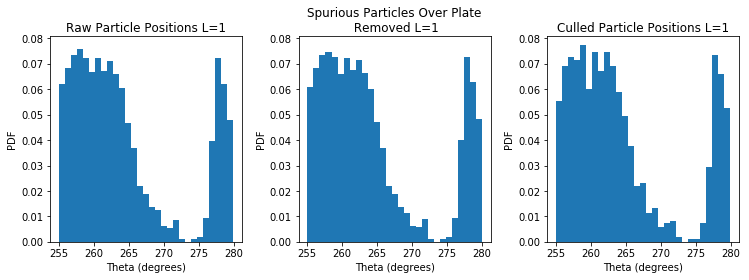

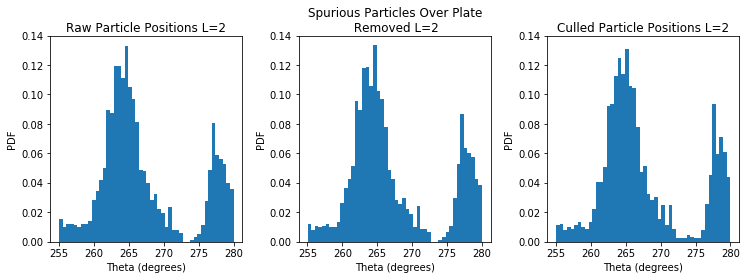

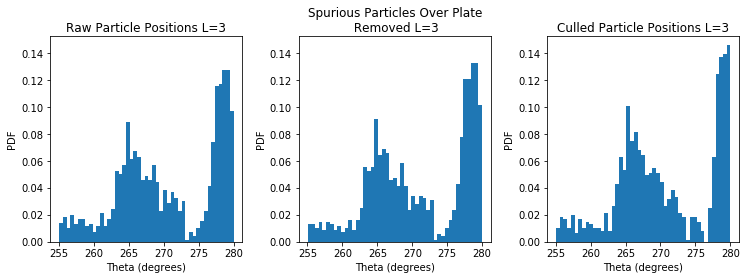

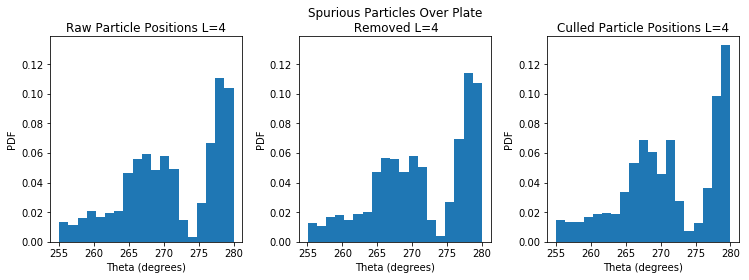

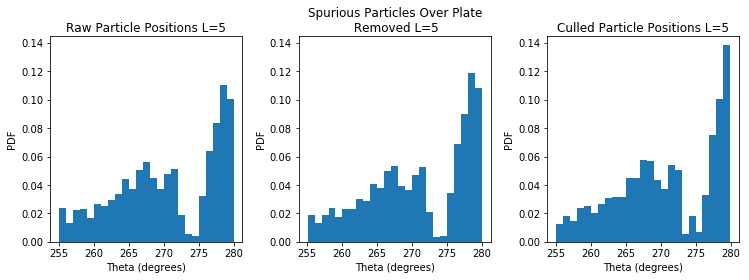

In [12]:
keys = store.index['key']
theta_range = [255, 280]
for l in range(5):
    plt.figure(figsize=[10.5,4])
    culled_positions = store.get(keys[l]).copy()
    culled_positions = culled_positions.drop_duplicates(['frame', 'track id'])
    culled_positions = culled_positions.query('@theta_range[0] < theta < @theta_range[1]')
    
    bin_num = hnf.hist_bin_optimization_continuous(culled_positions.theta)
    
    all_positions = transformed_data_list_proc[l].copy()
    all_positions = all_positions.query('@theta_range[0] < theta < @theta_range[1]')
    
    spurious_particles_removed = extra_particles_cleaned_up[l].copy()
    spurious_particles_removed = spurious_particles_removed.query('@theta_range[0] < theta < @theta_range[1]')
    
    ax1 = plt.subplot(131)
    plt.hist(all_positions.theta, bins=bin_num, normed=True)
    ylim1 = ax1.get_ylim()
    plt.xlabel('Theta (degrees)')
    plt.ylabel('PDF')
    plt.title('Raw Particle Positions L='+str(l+1))
    
    ax2 = plt.subplot(132)
    plt.hist(spurious_particles_removed.theta, bins=bin_num, normed=True)
    ylim2 = ax2.get_ylim()
    plt.xlabel('Theta (degrees)')
    plt.ylabel('PDF')
    plt.title('Spurious Particles Over Plate\n Removed L='+str(l+1))
    
    ax3 = plt.subplot(133)
    plt.hist(culled_positions.theta, bins=bin_num, normed=True)
    ylim3 = ax3.get_ylim()
    plt.xlabel('Theta (degrees)')
    plt.ylabel('PDF')
    plt.title('Culled Particle Positions L='+str(l+1))
    
    if ylim1 > ylim2 and ylim1 > ylim3:
        ax2.set_ylim(ax1.get_ylim())
        ax3.set_ylim(ax1.get_ylim())
    elif ylim2 > ylim1 and ylim2 > ylim3:
        ax1.set_ylim(ax2.get_ylim())
        ax3.set_ylim(ax2.get_ylim())
    else:# ylim3 > ylim1 and ylim3 > ylim2:
        ax1.set_ylim(ax3.get_ylim())
        ax2.set_ylim(ax3.get_ylim())
    
    plt.tight_layout()
    plt.show()

After removing the spurious particles over the nanoplate you can see that the effect on the histogram between the "Raw" positions and the "Spurious Particles Over Plate Removed" changed very little in the barrier region. There is very very small decrease of pdf in the 255-262 degree region. This is to be expected as this is where the spurious particles were commonly located. However, there is no change in the pdf in the 273-275 region. Like I mentioned, the spurious particles removed in this step are over the nanoplate not near the barrier.

## Effect of Dealing with particles doubled on nanoplate boundary

The background subtraction of the nanoplate barrier causes particles located directly on the barrier to be detected as two particles, one on the nanoplate and one off the nanoplate. I look at the effect of dealing with the particles on the nanoplate edge has on the histogram of particle positions. 

### Original Method: Midpoint Between Two Positions
The background subtraction of the nanoplate barrier causes particles located directly on the barrier to be detected as two particles, one on the nanoplate and one off the nanoplate. When one particle is seen doing this the midpoint of the two "fake" particles is taken as the true position of the particle. I compare the histogram of particle positions in theta of the original "Raw" positions, the positions of "Midpoint of Edge Particles", and the "Final Culled" positions.

In [13]:
x_box = [330, 330+13]
y_box = [390-186, 390-199]

false_pos = [[],
            [],
            [1958],
            [686, 1005, 1114, 1115, 1226],
            [1355],
            [520, 1439, 1489]]

missed_pos = [[],
              [939, 1886],
              [79, 988, 1090, 1069, 1332, 1474, 1701],
              [31, 84, 363, 364, 712, 772, 783, 1417, 1494],
              [1114, 1469, 1506, 1673, 1707],
              []]

y_box_missed = [390-183, 390-199]
x_box_missed = [328, 330+17]

def cut_out_particle_pairs_too_close_in_region(df, x_box, y_box, false_pos=None, missed_pos=None,x_box_missed=None, y_box_missed=None):    
    
    # Select particle pairs in the regular box
    temp = df[(df['x pos'] > x_box[0]) & (df['x pos'] < x_box[1])]
    temp = temp[(temp['y pos'] < y_box[0]) & (temp['y pos'] > y_box[1])]
    num_parts = temp.groupby('frame').apply(len)
    part_pairs = temp[temp['frame'].isin(num_parts[num_parts > 1].index)]
    
    # Exclude frames where false positives where found by hand
    if false_pos != None:
        part_pairs = part_pairs[~part_pairs['frame'].isin(false_pos)]
    
    # Include frames with a larger box where missed pairs were not identified
    if missed_pos != None and len(missed_pos) != 0:
        if x_box_missed != None:
            temp = df[(df['x pos'] > x_box_missed[0]) & (df['x pos'] < x_box_missed[1])]
        else:
            temp = df[(df['x pos'] > x_box[0]) & (df['x pos'] < x_box[1])]
        if y_box_missed != None:
            temp = temp[(temp['y pos'] < y_box_missed[0]) & (temp['y pos'] > y_box_missed[1])]
        else:
            temp = temp[(temp['y pos'] < y_box[0]) & (temp['y pos'] > y_box[1])]
    
        num_parts = temp.groupby('frame').apply(len)
        temp = temp[temp['frame'].isin(num_parts[num_parts > 1].index)]
        part_pairs_missed = temp[temp['frame'].isin(missed_pos)]
        part_pairs = pd.concat([part_pairs, part_pairs_missed], axis=0)
    
    # For particle pairs identified make the new position the mean of the positions
    # in the pair
    keep_idx = part_pairs.drop_duplicates('frame').sort_index().index
    trash_idx = part_pairs.drop_duplicates('frame', keep='last').sort_index().index
    new_xy = part_pairs[['frame', 'x pos', 'y pos']].groupby('frame').mean()
    new_df = df.copy()
    new_df.loc[keep_idx, ['x pos', 'y pos']] = new_xy.values
    new_df = new_df.drop(trash_idx)
    return new_df

In [14]:
culled_particles = []
for num, v in enumerate(extra_particles_cleaned_up):
    temp_df = cut_out_particle_pairs_too_close_in_region(v, x_box, y_box, false_pos[num], missed_pos[num], x_box_missed=x_box_missed,y_box_missed=y_box_missed)
    temp_fit_params = common_functions.least_sq_fit_circle(temp_df)
    common_functions.polar_coor_data_frame(temp_df, temp_fit_params[0], temp_fit_params[1])
    culled_particles.append(temp_df)

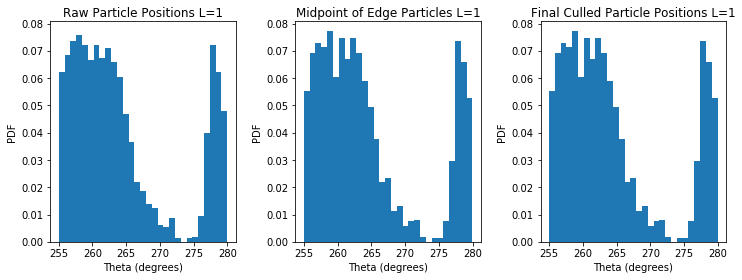

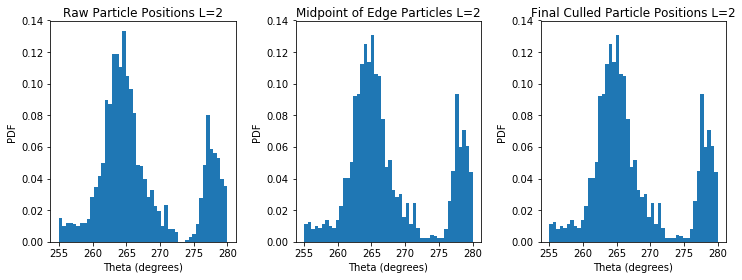

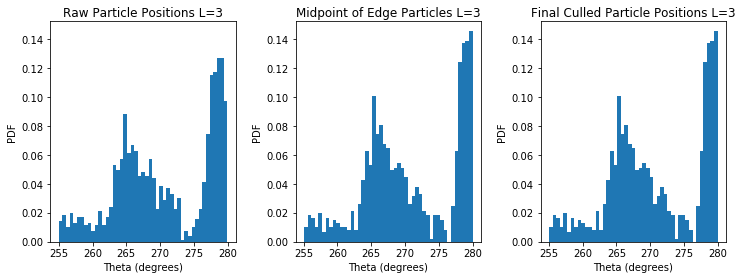

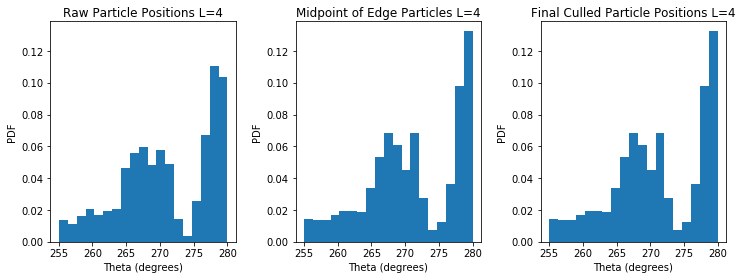

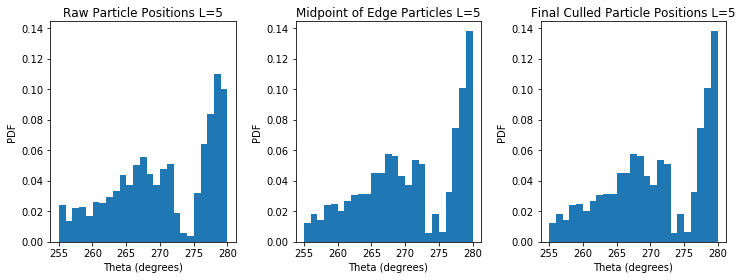

In [15]:
keys = store.index['key']
theta_range = [255, 280]
for l in range(5):
    plt.figure(figsize=[10.5,4])
    culled_positions = store.get(keys[l]).copy()
    culled_positions = culled_positions.drop_duplicates(['frame', 'track id'])
    culled_positions = culled_positions.query('@theta_range[0] < theta < @theta_range[1]')
    
    bin_num = hnf.hist_bin_optimization_continuous(culled_positions.theta)
    
    all_positions = transformed_data_list_proc[l].copy()
    all_positions = all_positions.query('@theta_range[0] < theta < @theta_range[1]')
    
    spurious_particles_removed = culled_particles[l].copy()
    spurious_particles_removed = spurious_particles_removed.query('@theta_range[0] < theta < @theta_range[1]')
    
    ax1 = plt.subplot(131)
    plt.hist(all_positions.theta, bins=bin_num, normed=True)
    ylim1 = ax1.get_ylim()
    plt.xlabel('Theta (degrees)')
    plt.ylabel('PDF')
    plt.title('Raw Particle Positions L='+str(l+1))
    
    ax2 = plt.subplot(132)
    plt.hist(spurious_particles_removed.theta, bins=bin_num, normed=True)
    ylim2 = ax2.get_ylim()
    plt.xlabel('Theta (degrees)')
    plt.ylabel('PDF')
    plt.title('Midpoint of Edge Particles L='+str(l+1))
    
    ax3 = plt.subplot(133)
    plt.hist(culled_positions.theta, bins=bin_num, normed=True)
    ylim3 = ax3.get_ylim()
    plt.xlabel('Theta (degrees)')
    plt.ylabel('PDF')
    plt.title('Final Culled Particle Positions L='+str(l+1))
    
    if ylim1 > ylim2 and ylim1 > ylim3:
        ax2.set_ylim(ax1.get_ylim())
        ax3.set_ylim(ax1.get_ylim())
    elif ylim2 > ylim1 and ylim2 > ylim3:
        ax1.set_ylim(ax2.get_ylim())
        ax3.set_ylim(ax2.get_ylim())
    else:# ylim3 > ylim1 and ylim3 > ylim2:
        ax1.set_ylim(ax3.get_ylim())
        ax2.set_ylim(ax3.get_ylim())
    
    plt.tight_layout()
    plt.show()

So you can see that this is the step in the processing of spurious particles that causes the increased probability density between 273-275 degrees. I have reviewed the particle positions by hand and they look to be pretty accuruate. One thing to consider is that one degree is about 2.64 pixels in the image. Like I mentioned, the positions look good by hand but I don't know if I can discern the position of the particle on the edge within 2 pixels by eye. I think this implementation does a good job of putting a particle in a location where we know there is a particle but I think there is some error in the position of the particle.

Perhaps there is a better way to do this cleaning up of particle positions using more information. I try other methods of determining the position of particles on the nanoplate below.

### Method 2: Weighted Average of Particles

It occured to me that the particle tracking software also provides the integrated intensity around the center of each particle. We know that if a particle is centered on the nanoplate edge that after background subtraction maxima of the particle's intensity will be become a minima after the edge of the nanoplate is subtracted. However, the sides of the particle (on either side of the nanoplate edge) is what is picked up by the particle tracking software. If the particle is slightly off center from the nanoplate edge then the integrated intensity should be higher on the it is off of.

Here instead of just calculating the midpoint between the two particles on the nanoplate edge I weight it based on the integrated intensity of each particle. This means if one of the two spurious particles has a higher integrated intensity then the true particle position is chosen slightly closer to that particle's position. The weighted average is implemented as:

$$\frac{\rm{Int_1} x_1 + \rm{Int_2} x_2}{\rm{Int_1} + \rm{Int_2}}$$

Where $x$ is either the x or y position of the particle and $\rm{Int}$ is the integrated intensity of the particle.

The histogram of of the "Raw" positions, the "Weighted Midpoint" of particles on edge, and the "Final Culled" positions are compare.

In [16]:
x_box = [330, 330+13]
y_box = [390-186, 390-199]

false_pos = [[],
            [],
            [1958],
            [686, 1005, 1114, 1115, 1226],
            [1355],
            [520, 1439, 1489]]

missed_pos = [[],
              [939, 1886],
              [79, 988, 1090, 1069, 1332, 1474, 1701],
              [31, 84, 363, 364, 712, 772, 783, 1417, 1494],
              [1114, 1469, 1506, 1673, 1707],
              []]

y_box_missed = [390-183, 390-199]
x_box_missed = [328, 330+17]

def cut_out_particle_pairs_too_close_in_region(df, x_box, y_box, false_pos=None, missed_pos=None,x_box_missed=None, y_box_missed=None):    
    
    # Select particle pairs in the regular box
    temp = df[(df['x pos'] > x_box[0]) & (df['x pos'] < x_box[1])]
    temp = temp[(temp['y pos'] < y_box[0]) & (temp['y pos'] > y_box[1])]
    num_parts = temp.groupby('frame').apply(len)
    part_pairs = temp[temp['frame'].isin(num_parts[num_parts > 1].index)]
    
    # Exclude frames where false positives where found by hand
    if false_pos != None:
        part_pairs = part_pairs[~part_pairs['frame'].isin(false_pos)]
    
    # Include frames with a larger box where missed pairs were not identified
    if missed_pos != None and len(missed_pos) != 0:
        if x_box_missed != None:
            temp = df[(df['x pos'] > x_box_missed[0]) & (df['x pos'] < x_box_missed[1])]
        else:
            temp = df[(df['x pos'] > x_box[0]) & (df['x pos'] < x_box[1])]
        if y_box_missed != None:
            temp = temp[(temp['y pos'] < y_box_missed[0]) & (temp['y pos'] > y_box_missed[1])]
        else:
            temp = temp[(temp['y pos'] < y_box[0]) & (temp['y pos'] > y_box[1])]
    
        num_parts = temp.groupby('frame').apply(len)
        temp = temp[temp['frame'].isin(num_parts[num_parts > 1].index)]
        part_pairs_missed = temp[temp['frame'].isin(missed_pos)]
        part_pairs = pd.concat([part_pairs, part_pairs_missed], axis=0)
    
    # For particle pairs identified make the new position the mean of the positions
    # in the pair
    keep_idx = part_pairs.drop_duplicates('frame').sort_index().index
    trash_idx = part_pairs.drop_duplicates('frame', keep='last').sort_index().index
    new_xy = part_pairs[['frame', 'x pos', 'y pos']].groupby('frame').mean()
    
    # This next line is for calculating the weighted average between the two
    # particles
    new_xy = part_pairs.groupby('frame').apply(weighted_avg_position)
    
    new_df = df.copy()
    new_df.loc[keep_idx, ['x pos', 'y pos']] = new_xy.values
    new_df = new_df.drop(trash_idx)
    return new_df

In [17]:
def weighted_avg_position(group):
    group_copy = group.copy()
    group_copy['x_weighted'] = group_copy['x pos'] * group_copy['intensity']
    group_copy['y_weighted'] = group_copy['y pos'] * group_copy['intensity']
    
    intensity_sum = group_copy['intensity'].sum()
    #print 'intensity='+str(intensity_sum)
    return group_copy[['x_weighted', 'y_weighted']].sum()/intensity_sum

In [18]:
culled_particles = []
for num, v in enumerate(extra_particles_cleaned_up):
    temp_df = cut_out_particle_pairs_too_close_in_region(v, x_box, y_box, false_pos[num], missed_pos[num], x_box_missed=x_box_missed,y_box_missed=y_box_missed)
    temp_fit_params = common_functions.least_sq_fit_circle(temp_df)
    common_functions.polar_coor_data_frame(temp_df, temp_fit_params[0], temp_fit_params[1])
    culled_particles.append(temp_df)

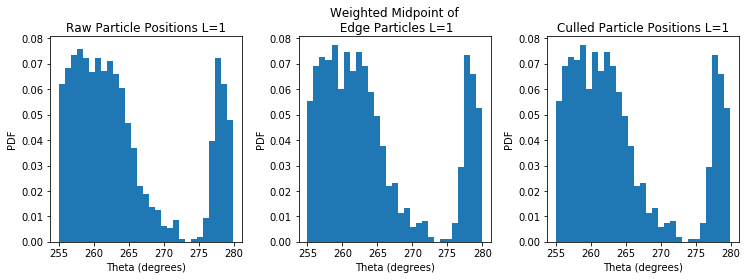

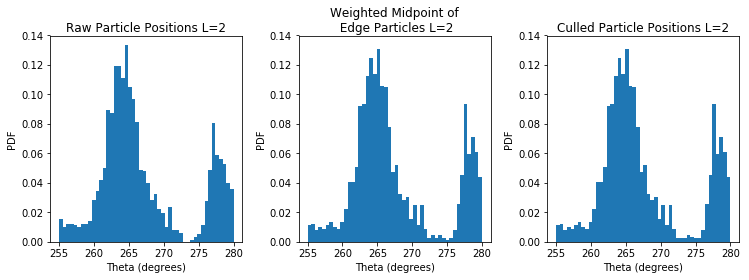

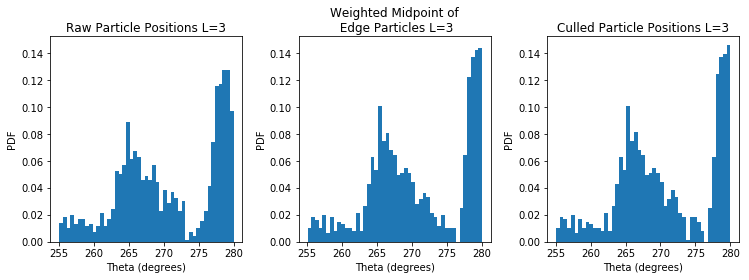

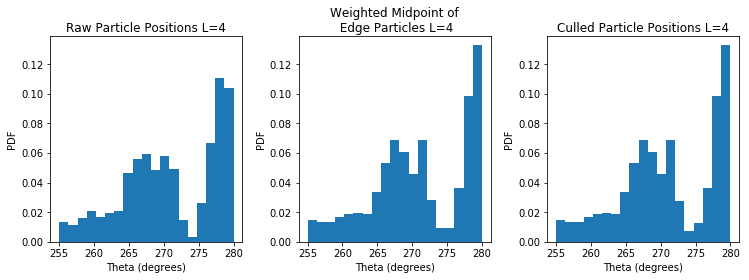

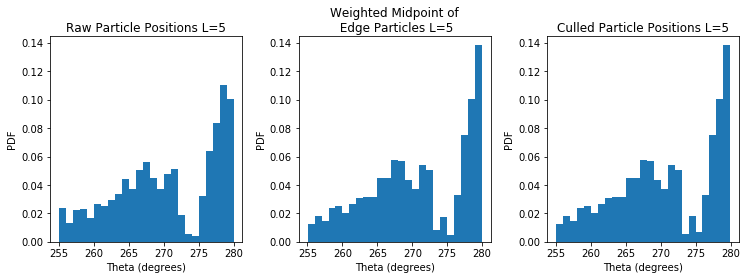

In [19]:
keys = store.index['key']
theta_range = [255, 280]
for l in range(5):
    plt.figure(figsize=[10.5,4])
    culled_positions = store.get(keys[l]).copy()
    culled_positions = culled_positions.drop_duplicates(['frame', 'track id'])
    culled_positions = culled_positions.query('@theta_range[0] < theta < @theta_range[1]')
    #r_avg_culled = culled_positions.r.mean()
    #culled_positions = culled_positions.query('@r_avg_culled - 10 < r < @r_avg_culled +10')
    
    bin_num = hnf.hist_bin_optimization_continuous(culled_positions.theta)
    
    all_positions = transformed_data_list_proc[l].copy()
    all_positions = all_positions.query('@theta_range[0] < theta < @theta_range[1]')
    #r_avg_all = all_positions.r.mean()
    #all_positions = all_positions.query('@r_avg_all - 10 < r < @r_avg_all +10')
    
    
    edge_particles_removed = culled_particles[l].copy()
    edge_particles_removed = edge_particles_removed.query('@theta_range[0] < theta < @theta_range[1]')
    #r_avg_weighted = edge_particles_removed.r.mean()
    #edge_particles_removed = edge_particles_removed.query('@r_avg_weighted - 10 < r < @r_avg_weighted +10')
    
    ax1 = plt.subplot(131)
    plt.hist(all_positions.theta, bins=bin_num, normed=True)
    ylim1 = ax1.get_ylim()
    plt.xlabel('Theta (degrees)')
    plt.ylabel('PDF')
    plt.title('Raw Particle Positions L='+str(l+1))
    
    ax2 = plt.subplot(132)
    plt.hist(edge_particles_removed.theta, bins=bin_num, normed=True)
    ylim2 = ax2.get_ylim()
    plt.xlabel('Theta (degrees)')
    plt.ylabel('PDF')
    plt.title('Weighted Midpoint of\n Edge Particles L='+str(l+1))
    
    ax3 = plt.subplot(133)
    plt.hist(culled_positions.theta, bins=bin_num, normed=True)
    ylim3 = ax3.get_ylim()
    plt.xlabel('Theta (degrees)')
    plt.ylabel('PDF')
    plt.title('Culled Particle Positions L='+str(l+1))
    
    if ylim1 > ylim2 and ylim1 > ylim3:
        ax2.set_ylim(ax1.get_ylim())
        ax3.set_ylim(ax1.get_ylim())
    elif ylim2 > ylim1 and ylim2 > ylim3:
        ax1.set_ylim(ax2.get_ylim())
        ax3.set_ylim(ax2.get_ylim())
    else:# ylim3 > ylim1 and ylim3 > ylim2:
        ax1.set_ylim(ax3.get_ylim())
        ax2.set_ylim(ax3.get_ylim())
    
    plt.tight_layout()
    plt.show()

~~With the weighted average in calculating the midpoint has the opposite effect and actually increases the probability density in the 273-275 region. In the case of L=3 the increased pdf reaches hilariously high value of 0.05 at 274 degrees.~~

__Update 1/4/2017:__
There was a bug in how the weighted average was calculated and it was doing it completely wrong. I have now fixed it so it is calculated correctly. This method actually improves the probability density in the 273-275 region so there isn't as much of a spike in the center. L=3 is still a little bit of a problem.

### Method 3: Weighted Average with Intensity Ratio

There is one piece of information that was not considered in the weighted midpoint treatment of particles on the edge. I know that the intensity of the particles is different over the glass versus over the nanoplate [Zijie Yan, _et. al._, Nano. Lett., (2014). DOI: 10.1021/nl500107w.] so perhaps this needs to be accounted for in the the weighted intensity average. Surprisingly  my data shows the opposite effect, that the average intensity of the nanoparticles over the nanoplate is actually less than the nanoparticles over the glass. The distribution of the integrated intensity of the particles over the glass and over the nanoplate are compared. In an effort to avoid errors in the integrated intensity only regions far from the boundaries were selected. For glass the region chosen was 290-20 degrees while over the nanoplate the region chosen was 120-260 degrees. The mean intensity of each over plate and over glass are reported in addition to the ratio of plate_mean/glass_mean.

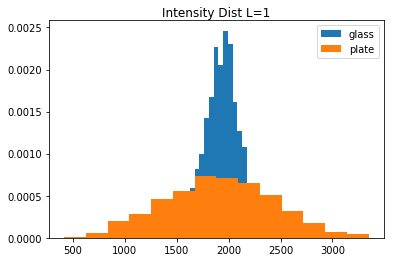

L = 1 Results Summary
Avg intensity plate: 1900.86295591
Avg intensity glass: 1914.15348525
Ratio plate/glass: 0.993056706556


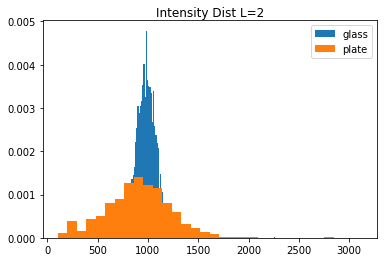

L = 2 Results Summary
Avg intensity plate: 903.051455396
Avg intensity glass: 966.411420821
Ratio plate/glass: 0.934437896677


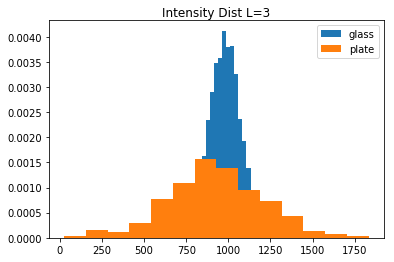

L = 3 Results Summary
Avg intensity plate: 925.626569398
Avg intensity glass: 969.082234375
Ratio plate/glass: 0.955157918043


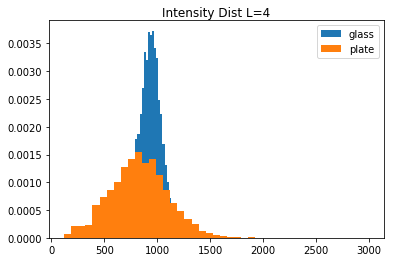

L = 4 Results Summary
Avg intensity plate: 829.44379223
Avg intensity glass: 915.338652574
Ratio plate/glass: 0.9061605668


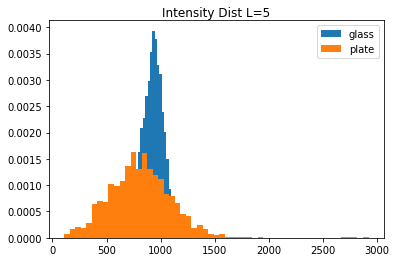

L = 5 Results Summary
Avg intensity plate: 811.52199609
Avg intensity glass: 893.043898287
Ratio plate/glass: 0.908714563356


In [20]:
for num, v in enumerate(extra_particles_cleaned_up):
    if num==5:
        continue
    over_plate_particles = v.query('120 < theta < 260')
    over_glass_particles = v.query('theta < 20 or theta > 290')
    
    plate_int_mean = over_plate_particles.intensity.mean()
    glass_int_mean = over_glass_particles.intensity.mean()
    
    bin_glass = hnf.hist_bin_optimization_continuous(over_glass_particles.intensity)
    bin_plate = hnf.hist_bin_optimization_continuous(over_plate_particles.intensity)

    plt.hist(over_glass_particles.intensity, bins=bin_glass, normed=True, label='glass')
    plt.hist(over_plate_particles.intensity, bins=bin_plate, normed=True, label='plate')
    plt.legend()
    plt.title('Intensity Dist L='+str(num+1))
    plt.show()
    
    print 'L = '+str(num+1)+' Results Summary'
    print 'Avg intensity plate: '+str(plate_int_mean)
    print 'Avg intensity glass: '+str(glass_int_mean)
    print 'Ratio plate/glass: '+str(plate_int_mean/glass_int_mean)

Like in __Method 2__ I can use the weighted average like I did before but using the ratio of the mean of the intensity of the plate/glass as a factor for changing the intensity of the glass. The new formula for the weighted averge becomes:

$$\frac{\rm{Int_p} x_p + \alpha \rm{Int_g} x_g}{\rm{Int_p} + \alpha \rm{Int_g}}$$

Where $\alpha$ = $\frac{\rm{Mean Plate Intensity}}{\rm{Mean Glass Intensity}}$ and $\rm{Int_p}$ and $\rm{Int_g}$ are the intensities for the particle found over the plate or glass respectfully.

I plot the distribution of particle positions in theta for the "Raw" positions, the "Weighted Midpoint of Edge Particles with Intensity Ratio", and the "Final Culled" positions.

In [21]:
x_box = [330, 330+13]
y_box = [390-186, 390-199]

false_pos = [[],
            [],
            [1958],
            [686, 1005, 1114, 1115, 1226],
            [1355],
            [520, 1439, 1489]]

missed_pos = [[],
              [939, 1886],
              [79, 988, 1090, 1069, 1332, 1474, 1701],
              [31, 84, 363, 364, 712, 772, 783, 1417, 1494],
              [1114, 1469, 1506, 1673, 1707],
              []]

y_box_missed = [390-183, 390-199]
x_box_missed = [328, 330+17]

def cut_out_particle_pairs_too_close_in_region(df, x_box, y_box, false_pos=None, missed_pos=None,x_box_missed=None, y_box_missed=None):    
    
    over_plate_particles = df.query('120 < theta < 260')
    over_glass_particles = df.query('theta < 20 or theta > 290')
    
    avg_int_plate = over_plate_particles.intensity.mean()
    avg_int_glass = over_glass_particles.intensity.mean()
    int_ratio = avg_int_plate/avg_int_glass
    
    # Select particle pairs in the regular box
    temp = df[(df['x pos'] > x_box[0]) & (df['x pos'] < x_box[1])]
    temp = temp[(temp['y pos'] < y_box[0]) & (temp['y pos'] > y_box[1])]
    num_parts = temp.groupby('frame').apply(len)
    part_pairs = temp[temp['frame'].isin(num_parts[num_parts > 1].index)]
    
    # Exclude frames where false positives where found by hand
    if false_pos != None:
        part_pairs = part_pairs[~part_pairs['frame'].isin(false_pos)]
    
    # Include frames with a larger box where missed pairs were not identified
    if missed_pos != None and len(missed_pos) != 0:
        if x_box_missed != None:
            temp = df[(df['x pos'] > x_box_missed[0]) & (df['x pos'] < x_box_missed[1])]
        else:
            temp = df[(df['x pos'] > x_box[0]) & (df['x pos'] < x_box[1])]
        if y_box_missed != None:
            temp = temp[(temp['y pos'] < y_box_missed[0]) & (temp['y pos'] > y_box_missed[1])]
        else:
            temp = temp[(temp['y pos'] < y_box[0]) & (temp['y pos'] > y_box[1])]
    
        num_parts = temp.groupby('frame').apply(len)
        temp = temp[temp['frame'].isin(num_parts[num_parts > 1].index)]
        part_pairs_missed = temp[temp['frame'].isin(missed_pos)]
        part_pairs = pd.concat([part_pairs, part_pairs_missed], axis=0)
    
    # For particle pairs identified make the new position the mean of the positions
    # in the pair
    keep_idx = part_pairs.drop_duplicates('frame').sort_index().index
    trash_idx = part_pairs.drop_duplicates('frame', keep='last').sort_index().index
    new_xy = part_pairs[['frame', 'x pos', 'y pos']].groupby('frame').mean()
    
    # This next line is for calculating the weighted average between the two
    # particles
    new_xy = part_pairs.groupby('frame').apply(weighted_avg_position, (int_ratio))
    
    new_df = df.copy()
    new_df.loc[keep_idx, ['x pos', 'y pos']] = new_xy.values
    new_df = new_df.drop(trash_idx)
    return new_df

In [22]:
def weighted_avg_position(group, int_ratio):
    group_copy = group.copy()
    
    group_glass = group_copy[group_copy['over_plate']==False].index
    group_copy.loc[group_glass, 'intensity'] *= int_ratio
    group_copy['x_weighted'] = group_copy['x pos'] * group_copy['intensity']
    group_copy['y_weighted'] = group_copy['y pos'] * group_copy['intensity']
    
    intensity_sum = group_copy['intensity'].sum()
    
    return group_copy[['x_weighted', 'y_weighted']].sum()/intensity_sum

In [23]:
culled_particles = []
for num, v in enumerate(extra_particles_cleaned_up):
    temp_df = cut_out_particle_pairs_too_close_in_region(v, x_box, y_box, false_pos[num], missed_pos[num], x_box_missed=x_box_missed,y_box_missed=y_box_missed)
    temp_fit_params = common_functions.least_sq_fit_circle(temp_df)
    common_functions.polar_coor_data_frame(temp_df, temp_fit_params[0], temp_fit_params[1])
    culled_particles.append(temp_df)

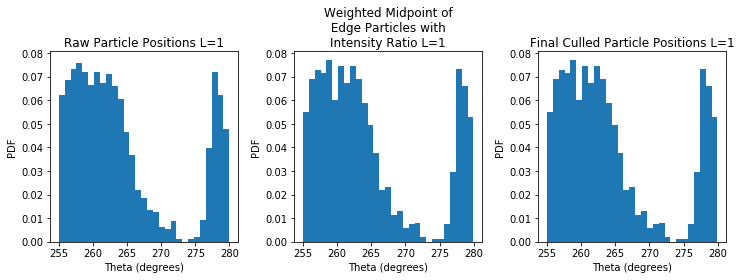

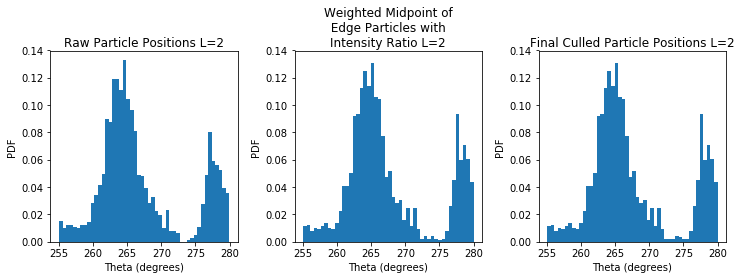

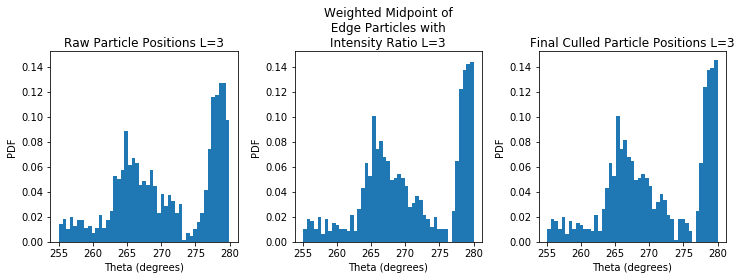

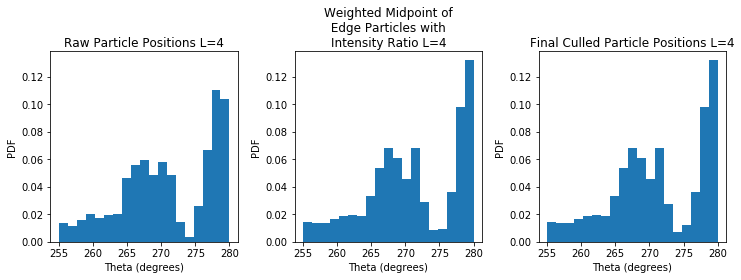

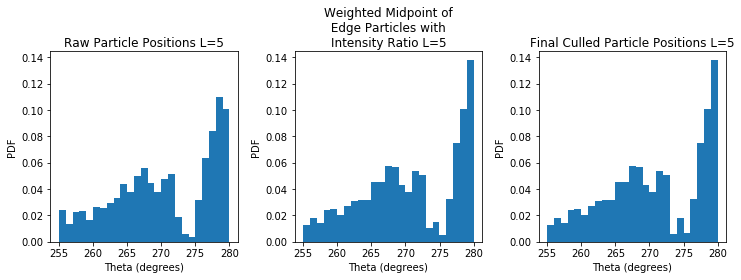

In [24]:
keys = store.index['key']
theta_range = [255, 280]
for l in range(5):
    plt.figure(figsize=[10.5,4])
    culled_positions = store.get(keys[l]).copy()
    culled_positions = culled_positions.drop_duplicates(['frame', 'track id'])
    culled_positions = culled_positions.query('@theta_range[0] < theta < @theta_range[1]')
    #r_avg_culled = culled_positions.r.mean()
    #culled_positions = culled_positions.query('@r_avg_culled - 10 < r < @r_avg_culled +10')
    
    bin_num = hnf.hist_bin_optimization_continuous(culled_positions.theta)
    
    all_positions = transformed_data_list_proc[l].copy()
    all_positions = all_positions.query('@theta_range[0] < theta < @theta_range[1]')
    #r_avg_all = all_positions.r.mean()
    #all_positions = all_positions.query('@r_avg_all - 10 < r < @r_avg_all +10')

    edge_particles_removed = culled_particles[l].copy()
    edge_particles_removed = edge_particles_removed.query('@theta_range[0] < theta < @theta_range[1]')
    #r_avg_weighted = edge_particles_removed.r.mean()
    #edge_particles_removed = edge_particles_removed.query('@r_avg_weighted - 10 < r < @r_avg_weighted +10')

    ax1 = plt.subplot(131)
    plt.hist(all_positions.theta, bins=bin_num, normed=True)
    ylim1 = ax1.get_ylim()
    plt.xlabel('Theta (degrees)')
    plt.ylabel('PDF')
    plt.title('Raw Particle Positions L='+str(l+1))
    
    ax2 = plt.subplot(132)
    plt.hist(edge_particles_removed.theta, bins=bin_num, normed=True)
    ylim2 = ax2.get_ylim()
    plt.xlabel('Theta (degrees)')
    plt.ylabel('PDF')
    plt.title('Weighted Midpoint of\n Edge Particles with \nIntensity Ratio L='+str(l+1))
    
    ax3 = plt.subplot(133)
    plt.hist(culled_positions.theta, bins=bin_num, normed=True)
    ylim3 = ax3.get_ylim()
    plt.xlabel('Theta (degrees)')
    plt.ylabel('PDF')
    plt.title('Final Culled Particle Positions L='+str(l+1))
    
    if ylim1 > ylim2 and ylim1 > ylim3:
        ax2.set_ylim(ax1.get_ylim())
        ax3.set_ylim(ax1.get_ylim())
    elif ylim2 > ylim1 and ylim2 > ylim3:
        ax1.set_ylim(ax2.get_ylim())
        ax3.set_ylim(ax2.get_ylim())
    else:# ylim3 > ylim1 and ylim3 > ylim2:
        ax1.set_ylim(ax3.get_ylim())
        ax2.set_ylim(ax3.get_ylim())
    
    plt.tight_layout()
    plt.show()

~~Here you can see that the new __Method 3__ does not have this issue of increased pdf in the 273 to 275 region like the simple midpoint method does. Perhaps this is the way we should be doing the analysis? I think we need to have a discussion on this because while I feel like everything I did was justified, I am not really sure if this is the correct way of doing things.~~

__Update 1/4/2017:__
A bug was found that cause scaled weighted average to be calculated incorrectly that has since been corrected. This shows a marginal improvement in the 273-275 region compared to the simple weighted average. The barrier looks much better after selecting in r around r_avg. This is the way that I will solve these particle pairs over the nanoplate edge and I will make the correction to __Ana_16061201__ and update the database so that it has the new values.